## Distributed Audio to Text Processing Pipeline using DeepSpeech & Dask

Steps:

0. [Pre-requisites](#Pre-requisites)
1. [Get list of all .wav files from S3 Bucket where Audio Files are stored](#Step-1:-Get-List-of-All-.wav-files-from-S3)
2. [Create a pipeline to:](#Step-2:-Create-Pipeline)
 * [Copy a single file from s3 to local disk](#Step-2a:-Copy-S3-file-to-local-disk)
 * [Extract metadata from audio file on disk](#Step-2b:-Extract-Metadata-from-localfile)
 * [Extract text from audio](#Step-2c:-Extract-text-from-local-audio-file)
 * [Merge all metadata, text data into one json file](#Step-2d:-Combine-properties-and-text)
 * [Write output to a local file](#Step-2e:-Write-output-to-localfile)
3. Run pipeline on a single file
4. [Distributed Processing using Dask](#Distributed-Processing-using-Dask)
 * Create a Dask Client with Slurm Cluster
 * Show Computational Directed Acyclic Graphs


## Pre-requisites

1. Install ffmpeg, sox, graphviz, deepspeech
2. Download deepspeech models

Run all the commands below from home directory
```
%%bash
cd
sudo apt-get install ffmpeg sox graphviz
pip install --user graphviz 
pip install --user --upgrade deepspeech
# Download pre-trained English model and extract
curl -LO https://github.com/mozilla/DeepSpeech/releases/download/v0.5.1/deepspeech-0.5.1-models.tar.gz
tar xvf deepspeech-0.5.1-models.tar.gz

# Download example audio files
curl -LO https://github.com/mozilla/DeepSpeech/releases/download/v0.5.1/audio-0.5.1.tar.gz
tar xvf audio-0.5.1.tar.gz
```

## Step 1: Get List of All .wav files from S3

In [35]:
import boto3
from tqdm import tqdm_notebook, tqdm
from pydub import AudioSegment

import argparse
import numpy as np
import shlex
import subprocess
import sys
import wave

from deepspeech import Model, printVersions
from timeit import default_timer as timer

try:
    from shhlex import quote
except ImportError:
    from pipes import quote
    
import datetime
import dask
import json

In [36]:
def get_matching_s3_objects(bucket, prefix="", suffix=""):
    """
    Generate objects in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch objects whose key starts with
        this prefix (optional).
    :param suffix: Only fetch objects whose keys end with
        this suffix (optional).
    """
    s3 = boto3.client("s3")
    paginator = s3.get_paginator("list_objects_v2")

    kwargs = {'Bucket': bucket}

    # We can pass the prefix directly to the S3 API.  If the user has passed
    # a tuple or list of prefixes, we go through them one by one.
    if isinstance(prefix, str):
        prefixes = (prefix, )
    else:
        prefixes = prefix

    for key_prefix in prefixes:
        kwargs["Prefix"] = key_prefix

        for page in paginator.paginate(**kwargs):
            try:
                contents = page["Contents"]
            except KeyError:
                return

            for obj in contents:
                key = obj["Key"]
                if key.endswith(suffix):
                    yield obj


def get_matching_s3_keys(bucket, prefix="", suffix=""):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    :param suffix: Only fetch keys that end with this suffix (optional).
    """
    for obj in get_matching_s3_objects(bucket, prefix, suffix):
        yield obj["Key"]

In [37]:
bucket = "rmlprojectsbucket"
prefix = "santirocketml/clarao54xf/audio_files/"
suffix = ".wav"
file_list = []
for key in tqdm_notebook(get_matching_s3_keys(bucket=bucket,prefix=prefix,suffix=suffix)):
    file_list.append("s3://"+bucket+"/"+key)

## Step 2: Create Pipeline 

### Step 2a: Copy S3 file to local disk

In [38]:
!mkdir -p /shared/audio_to_text_output

In [39]:
def download_file_from_s3(s3_filename):
    s3 = boto3.client('s3')
    bucket_name = s3_filename.split("s3://")[1].split("/")[0]
    object_name = '/'.join(s3_filename.split("s3://")[1].split("/")[1:])
    local_filename = s3_filename.split("/")[-1]
    filename = "/shared/audio_files/"+local_filename
    print(filename)
    s3.download_file(bucket_name,object_name,filename)
    return filename

### Step 2b: Extract Metadata from localfile

In [40]:
def get_audio_properties(filename):
    sound = AudioSegment.from_wav(filename)
    properties = {}
    properties["loudness"]          = sound.dBFS
    properties["channels"]          = sound.channels
    properties["bytes_per_sample"]  = sound.sample_width
    properties["frames_per_second"] = sound.frame_rate
    properties["bytes_per_frame"]   = sound.frame_width
    properties["peak_amplitude"]    = sound.max
    properties["duration"]          = str(datetime.timedelta(milliseconds=len(sound)))

    return properties

### Step 2c: Extract text from local audio file

In [41]:
def convert_samplerate(audio_path):
    sox_cmd = 'sox {} --type raw --bits 16 --channels 1 --rate 16000 --encoding signed-integer --endian little --compression 0.0 --no-dither - '.format(quote(audio_path))
    try:
        output = subprocess.check_output(shlex.split(sox_cmd), stderr=subprocess.PIPE)
    except subprocess.CalledProcessError as e:
        raise RuntimeError('SoX returned non-zero status: {}'.format(e.stderr))
    except OSError as e:
        raise OSError(e.errno, 'SoX not found, use 16kHz files or install it: {}'.format(e.strerror))

    return 16000, np.frombuffer(output, np.int16)

def audio_to_text(filename):
    model_load_start = timer()
    BEAM_WIDTH = 500

    # The alpha hyperparameter of the CTC decoder. Language Model weight
    LM_ALPHA = 0.75

    # The beta hyperparameter of the CTC decoder. Word insertion bonus.
    LM_BETA = 1.85

    # These constants are tied to the shape of the graph used (changing them changes
    # the geometry of the first layer), so make sure you use the same constants that
    # were used during training

    # Number of MFCC features to use
    N_FEATURES = 26

    # Size of the context window used for producing timesteps in the input vector
    N_CONTEXT = 9
    
    # Model Files
    model_file = "/home/ubuntu/deepspeech-0.5.1-models/output_graph.pb"
    alphabet_file = "/home/ubuntu/deepspeech-0.5.1-models/alphabet.txt"
    lm_file = "/home/ubuntu/deepspeech-0.5.1-models/lm.binary"
    trie_file = "/home/ubuntu/deepspeech-0.5.1-models/trie"
    
    ds = Model(model_file, N_FEATURES, N_CONTEXT, alphabet_file, BEAM_WIDTH)
    model_load_end = timer() - model_load_start
    print('Loaded model in {:.3}s.'.format(model_load_end), file=sys.stderr)


    lm_load_start = timer()
    ds.enableDecoderWithLM(alphabet_file,lm_file,trie_file, LM_ALPHA, LM_BETA)
    lm_load_end = timer() - lm_load_start

    fin = wave.open(filename, 'rb')
    fs = fin.getframerate()
    if fs != 16000:
        print('Warning: original sample rate ({}) is different than 16kHz. Resampling might produce erratic speech recognition.'.format(fs), file=sys.stderr)
        fs, audio = convert_samplerate(filename)
    else:
        audio = np.frombuffer(fin.readframes(fin.getnframes()), np.int16)

    audio_length = fin.getnframes() * (1/16000)
    fin.close()

    print('Running inference.', file=sys.stderr)
    inference_start = timer()
    output_text = ds.stt(audio, fs)
    inference_end = timer() - inference_start
    print('Inference took %0.3fs for %0.3fs audio file.' % (inference_end, audio_length), file=sys.stderr)
    return output_text

### Step 2d: Combine properties and text

In [42]:
def merge_properties_and_text(properties,text):
    properties["deepspeech_text"] = text
    return properties

### Step 2e: Write output to localfile

In [43]:
def save_to_file(output_dict,location):
    with open(location,"w") as outfile:
        json.dump(output_dict,outfile)

## Distributed Processing using Dask

In [44]:
from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=4,memory='14 GB')
cluster.scale(4)
client = Client(cluster)

In [45]:
client

Client Scheduler: tcp://172.31.33.28:38528 Dashboard: http://172.31.33.28:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [46]:
output = []
for _file in tqdm(file_list[0:8]):
    filename     = dask.delayed(download_file_from_s3)(_file)
    properties   = dask.delayed(get_audio_properties)(filename)
    output_text  = dask.delayed(audio_to_text)(filename)
    final_output = dask.delayed(merge_properties_and_text)(properties,output_text)
    output.append(final_output)

100%|██████████| 8/8 [00:00<00:00, 2558.28it/s]


In [47]:
final = dask.delayed(save_to_file)(output,"/shared/audio_to_text_output/output_4.json")

## Show Computational Directed Acyclic Graphs

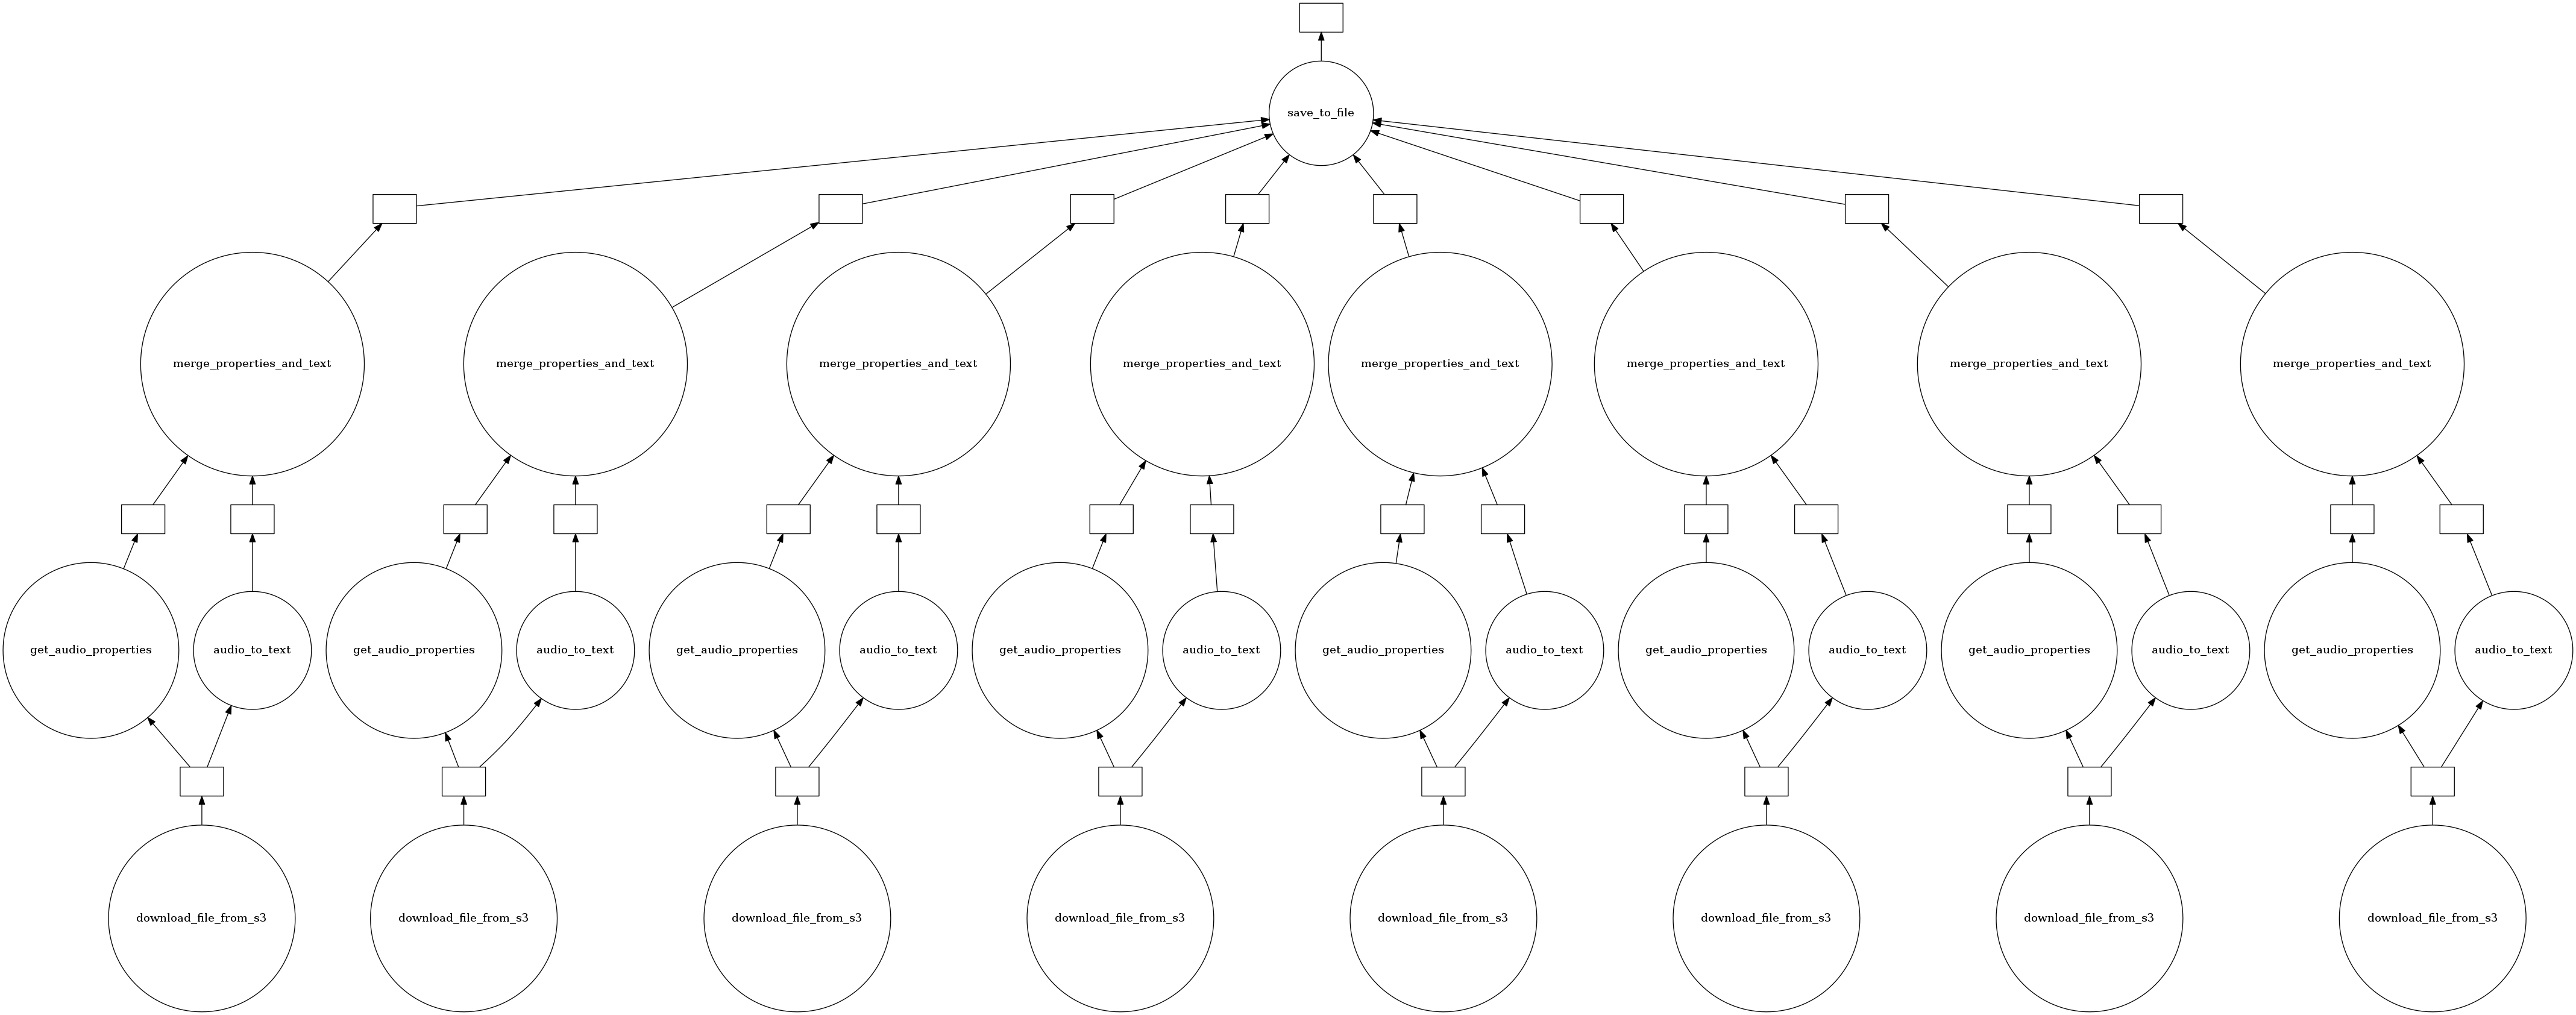

In [48]:
final.visualize()

In [49]:
%%time
final.compute()

CPU times: user 3.78 s, sys: 164 ms, total: 3.94 s
Wall time: 1min 6s


In [50]:
cluster.close()

In [51]:
client.close()

In [55]:
!sinfo

PARTITION AVAIL  TIMELIMIT  NODES  STATE NODELIST
compute*     up   infinite      4   idle ip-172-31-33-150,ip-172-31-37-226,ip-172-31-41-[164,241]


In [53]:
%reset -s -f

In [54]:
!python -m json.tool /shared/audio_to_text_output/output_4.json

[
    {
        "loudness": -30.948684419321516,
        "channels": 1,
        "bytes_per_sample": 2,
        "frames_per_second": 16000,
        "bytes_per_frame": 2,
        "peak_amplitude": 16439,
        "duration": "0:01:00.620000",
        "deepspeech_text": "there's one guy like that in every bunch the cook was mad at us for griping about his coffee so our group of scientists on this cockeyed saturn expedition were getting whole weak flower as punishment while captain muller probably sat in his cabin chuckling about it in our agreement there was a cloth that we could go over mutes had on such things with a unanimous petition but rigged at spite that the idiot light brand in his flower even for pancakes or else he was putting on a good act for the fun of watching the rest of us suffer you can take your damned hole weed and stuff it i started then i shrugged and dropped it there were enough few going on aboard the cranky who seeing jennison ing till he studied me and some only s